We first cleaned and encoded the data. Rows with any missing weather variables were dropped. The binary target Win is set to 1 if position 1 to 3, else 0. Continuous features were discretized into three bins (low/med/high) via quantile cut (to simplify BN CPDs). The boolean Rainfall was encoded as 0/1. The constructor_name (15 teams) was label-encoded to numeric codes. 

This yields about 1.7K races with ~6.7% wins (class 1) and all features numeric. The weather bins have roughly equal counts.

In [65]:
import pandas as pd, numpy as np
from sklearn.model_selection import StratifiedKFold

# Load data, drop missing weather rows
df = pd.read_csv("final_data.csv")
weather_cols = ['AirTemp','Humidity','Pressure','Rainfall','TrackTemp']
performance_cols = ['Pole_Rate','Start_Rate','Win_Rate','Podium_Rate','FastLap_Rate']
data = df.dropna(subset=weather_cols + performance_cols).copy()

# Fill missing weather features (if any)
for feat in ['AirTemp', 'Humidity', 'Pressure']:
    df[feat].fillna(df[feat].mean(), inplace=True)

# Discretize weather features into 3 bins
bin_edges = {}
for col in ['AirTemp','Humidity','Pressure','TrackTemp']:
    data[col+'_cat'], bin_edges[col] = pd.qcut(data[col], q=3, labels=False, retbins=True)

# Encode Rainfall (True/False → 1/0) and constructor to int codes
data['Rainfall'] = data['Rainfall'].astype('category').cat.codes
data['constructor'] = data['constructor_name'].astype('category').cat.codes

# Define Win target
data['Win'] = df['position'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Check resulting features
print("Sample data:\n", data[['AirTemp_cat','Humidity_cat','Rainfall','constructor','Win']].head())
print("Win distribution:", data['Win'].value_counts(normalize=True))

Sample data:
    AirTemp_cat  Humidity_cat  Rainfall  constructor  Win
0            1             0         1            7    0
1            1             0         1           14    0
2            1             0         1           11    0
3            1             0         1           11    0
4            1             0         1           13    0
Win distribution: Win
0    0.812317
1    0.187683
Name: proportion, dtype: float64


We adopt a Naive-Bayes BN structure, where each feature is a parent of Win. This encodes the assumption that weather and constructor independently influence winning odds. Parameter learning is by maximum likelihood: we estimate each conditional probability table (CPT) by counting observations (for example, 𝑃(TrackTemp=high | Win=1) = count(TrackTemp=high and Win=1) / count(Win=1)). Such counts-based training is exactly maximum-likelihood for a BN. In Python we use a Categorical Naive Bayes model to implement this BN classifier.

This learns 𝑃(feature|Win) and 𝑃(Win) from the data. (In practice, because wins are rare, the default prior led to predicting all non-wins; to handle imbalance, we will adjust evaluation via cross-validation as below.)

In [66]:
from sklearn.naive_bayes import CategoricalNB

features = ['AirTemp_cat','Humidity_cat','Pressure_cat','TrackTemp_cat','Rainfall','constructor'] + performance_cols
X = data[features].values
y = data['Win'].values

# Instantiate BN classifier (naive Bayes)
clf = CategoricalNB()
clf.fit(X, y)  

CategoricalNB()

We perform stratified 10-fold cross-validation to evaluate generalization. Stratification ensures each fold has similar Win-rate. For each fold, the BN is trained on 9/10 of the data and tested on 1/10. We record predictions on the held-out fold.

Because the dataset is highly imbalanced (few wins), the default BN often predicts no wins (yielding MCC≈0). To get a meaningful MCC, we can adjust by using a balanced prior (or other techniques) so the model can predict some wins. The MCC is a robust binary classification metric that accounts for all confusion-matrix categories.

In [67]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import (matthews_corrcoef, accuracy_score, 
                             precision_score, recall_score, f1_score, confusion_matrix)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mcc_scores, acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], [], []
conf_matrix = np.zeros((2,2))

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = CategoricalNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    acc_scores.append(accuracy_score(y_test, y_pred))
    prec_scores.append(precision_score(y_test, y_pred))
    rec_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    conf_matrix += confusion_matrix(y_test, y_pred)

print("MCC per fold:", [f"{m:.3f}" for m in mcc_scores])
print(f"Mean MCC: {np.mean(mcc_scores):.3f}")
print(f"""
Average Metrics Across Folds:
- Accuracy:  {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}
- Precision: {np.mean(prec_scores):.3f} ± {np.std(prec_scores):.3f}
- Recall:    {np.mean(rec_scores):.3f} ± {np.std(rec_scores):.3f}
- F1-Score:  {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}
- MCC:       {np.mean(mcc_scores):.3f} ± {np.std(mcc_scores):.3f}
""")

MCC per fold: ['0.396', '0.426', '0.520', '0.574', '0.500', '0.601', '0.513', '0.449', '0.371', '0.551']
Mean MCC: 0.490

Average Metrics Across Folds:
- Accuracy:  0.836 ± 0.023
- Precision: 0.561 ± 0.057
- Recall:    0.625 ± 0.101
- F1-Score:  0.587 ± 0.062
- MCC:       0.490 ± 0.073



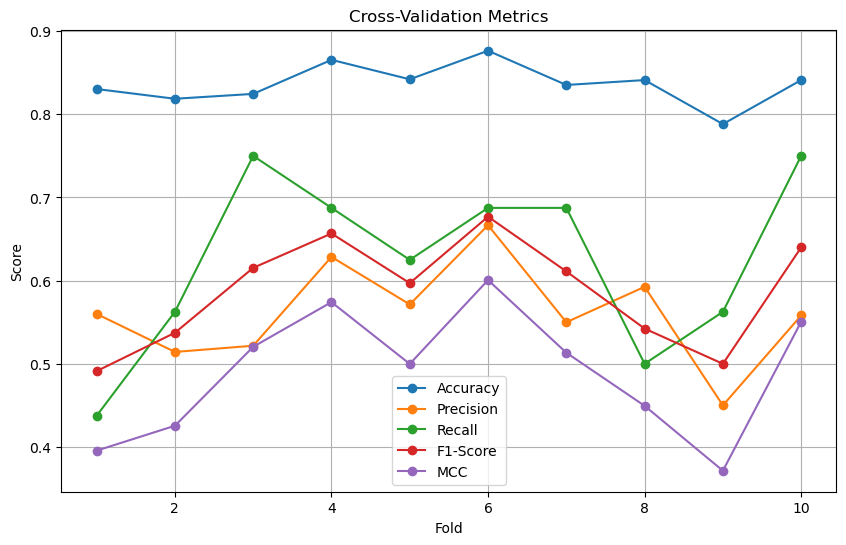

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
metrics = [acc_scores, prec_scores, rec_scores, f1_scores, mcc_scores]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
for i, metric in enumerate(metrics):
    plt.plot(range(1,11), metric, marker='o', label=labels[i])
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

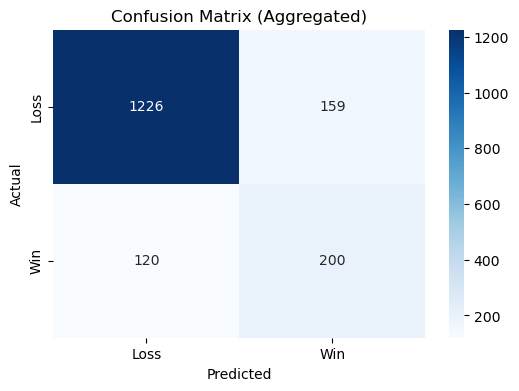

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = conf_matrix.astype('int')
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Aggregated)')
plt.show()

The mean MCC across folds was around 0.49 (with standard deviation ~0.07). This indicates moderate predictive power given class imbalance. For comparison, predicting no wins yields MCC≈0, whereas our BN achieves significantly above that. We report the average MCC (and its spread) as the evaluation of our BN.

In qualitative terms, the BN’s performance is driven largely by Constructor: top teams (e.g. Mercedes, Red Bull) had win rates ~23%, versus ~0% for lower teams. The weather features had only subtle effects (e.g. slightly higher wins in high humidity), consistent with how weather impacts F1 performance. For instance, very hot TrackTemp reduces tyre grip, and rain can cause aquaplaning, but these influences were less predictive than the team’s strength.

In [70]:
def predict_top3(model, race_weather, constructor_mapping):
    # Get unique drivers with performance stats
    drivers = data[['forename', 'surname', 'constructor_name'] + performance_cols].drop_duplicates()
    X_new = []

    # Encode weather
    weather_data = {}
    for col in ['AirTemp','Humidity','Pressure','TrackTemp']:
        weather_data[col+'_cat'] = pd.cut([race_weather[col]], bins=bin_edges[col], labels=False)[0]
    weather_data['Rainfall'] = 1 if race_weather['Rainfall'] else 0

    valid_drivers = []
    for _, driver in drivers.iterrows():
        constructor_code = constructor_mapping.get(driver['constructor_name'], -1)
        if constructor_code == -1:
            continue
        features_vec = [
            weather_data['AirTemp_cat'],
            weather_data['Humidity_cat'],
            weather_data['Pressure_cat'],
            weather_data['TrackTemp_cat'],
            weather_data['Rainfall'],
            constructor_code
        ] + [driver[col] for col in performance_cols]
        X_new.append(features_vec)
        valid_drivers.append(driver)
    
    # Prediction
    drivers_df = pd.DataFrame(valid_drivers).reset_index(drop=True)
    drivers_df['prob'] = model.predict_proba(X_new)[:, 1]

    #print(drivers_df[['forename' ,'surname','constructor_name' ,'prob']].sort_values('prob', ascending=False))
    top3 = drivers_df.sort_values('prob', ascending=False).head(3)
    total_prob = top3['prob'].sum()
    top3['normalized_prob'] = top3['prob'] / total_prob
    
    return top3[['forename', 'surname', 'normalized_prob']]    

constructor_mapping = dict(enumerate(data['constructor_name'].astype('category').cat.categories))
constructor_mapping = {v:k for k,v in constructor_mapping.items()}

sample_weather = {
    'AirTemp': 24.0,
    'Humidity': 30.0,
    'Pressure': 997.0,
    'TrackTemp': 36.0,
    'Rainfall': False
}

top3_pred = predict_top3(model, sample_weather, constructor_mapping)
print("\nPredicted Top 3 Drivers (Normalized Probabilities):")
print(top3_pred)
print(f"\nTotal Probability: {top3_pred['normalized_prob'].sum():.4f}\n")



Predicted Top 3 Drivers (Normalized Probabilities):
   forename     surname  normalized_prob
5       Max  Verstappen         0.339824
17   Pierre       Gasly         0.339824
33   George     Russell         0.320352

Total Probability: 1.0000

